In [1]:
import datetime

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from src.dataset import OzeDataset, OzeEvaluationDataset, OzeNPZDataset
from src.utils import npz_check
from src.model import BenchmarkLSTM
from time_series_transformer import Transformer

# Parameters

In [2]:
BATCH_SIZE = 4
NUM_WORKERS = 4
LR = 1e-2
EPOCHS = 5
HIDDEN_DIM = 100
# net_type = "transformer"
net_type = "lstm"

# device = torch.device("cpu")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device {device}")

Using device cuda:0


# Train the benchmark

### Load the dataset

In [3]:
dataset = OzeNPZDataset(dataset_path=npz_check("datasets", "dataset"), labels_path="labels.json")
# dataset = OzeDataset(dataset_x_path="datasets/x_train_LsAZgHU.csv", dataset_y_path="datasets/y_train_EFo1WyE.csv", labels_path="labels.json")
K = dataset.get_x_shape()[1]

dataloader = DataLoader(dataset,
                        batch_size=BATCH_SIZE,
                        shuffle=True,
                        num_workers=NUM_WORKERS)

m, M = dataloader.dataset.m, dataloader.dataset.M

### Load the network

In [4]:
d_input = dataset.get_x_shape()[2]  # From dataset
d_output = dataset.get_y_shape()[2]  # From dataset
D_MODEL = HIDDEN_DIM
if net_type == "lstm":
# Load benchmark network with Adam optimizer and MSE loss function
    net = BenchmarkLSTM(input_dim=d_input, hidden_dim=D_MODEL, output_dim=d_output, num_layers=3).to(device)
elif net_type == "transformer":
    # Model parameters
    Q = 8 # Query size
    V = 8 # Value size
    H = 8 # Number of heads
    N = 4 # Number of encoder and decoder to stack
    ATTENTION_SIZE = 12 # Attention window size
    DROPOUT = 0.2 # Dropout rate
    PE = None # Positional encoding
    CHUNK_MODE = None
    net = Transformer(d_input, D_MODEL, d_output, Q, V, H, N, attention_size=ATTENTION_SIZE, dropout=DROPOUT, chunk_mode=CHUNK_MODE, pe=PE).to(device)
optimizer = optim.Adam(net.parameters(), lr=LR)
loss_function = nn.MSELoss()

### Train the network

[Epoch   5/5]: 100%|██████████| 7500/7500 [03:07<00:00, 40.01it/s, loss=0.00305]
model exported to model_2020_05_10__171649.pth with loss 0.003051


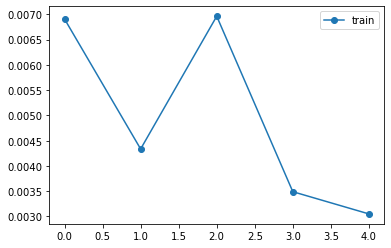

In [5]:
model_save_path = f'model_{datetime.datetime.now().strftime("%Y_%m_%d__%H%M%S")}.pth'
train_loss_best = np.inf

# Prepare loss history
hist_loss = np.zeros(EPOCHS)
for idx_epoch in range(EPOCHS):
    running_loss = 0
    with tqdm(total=len(dataloader.dataset), desc=f"[Epoch {idx_epoch+1:3d}/{EPOCHS}]") as pbar:
        for idx_batch, (x, y) in enumerate(dataloader):
            optimizer.zero_grad()

            # Propagate input
            netout = net(x.to(device))

            # Comupte loss
            loss = loss_function(y.to(device), netout)

            # Backpropage loss
            loss.backward()

            # Update weights
            optimizer.step()

            running_loss += loss.item()
            pbar.set_postfix({'loss': running_loss/(idx_batch+1)})
            pbar.update(x.shape[0])

        train_loss = running_loss/len(dataloader)
        pbar.set_postfix({'loss': train_loss})

        hist_loss[idx_epoch] = train_loss

        if train_loss < train_loss_best:
            train_loss_best = train_loss
            torch.save(net.state_dict(), model_save_path)

plt.plot(hist_loss, 'o-', label='train')
plt.legend()
print(f"model exported to {model_save_path} with loss {train_loss_best:5f}")

### Plot the results for a training example

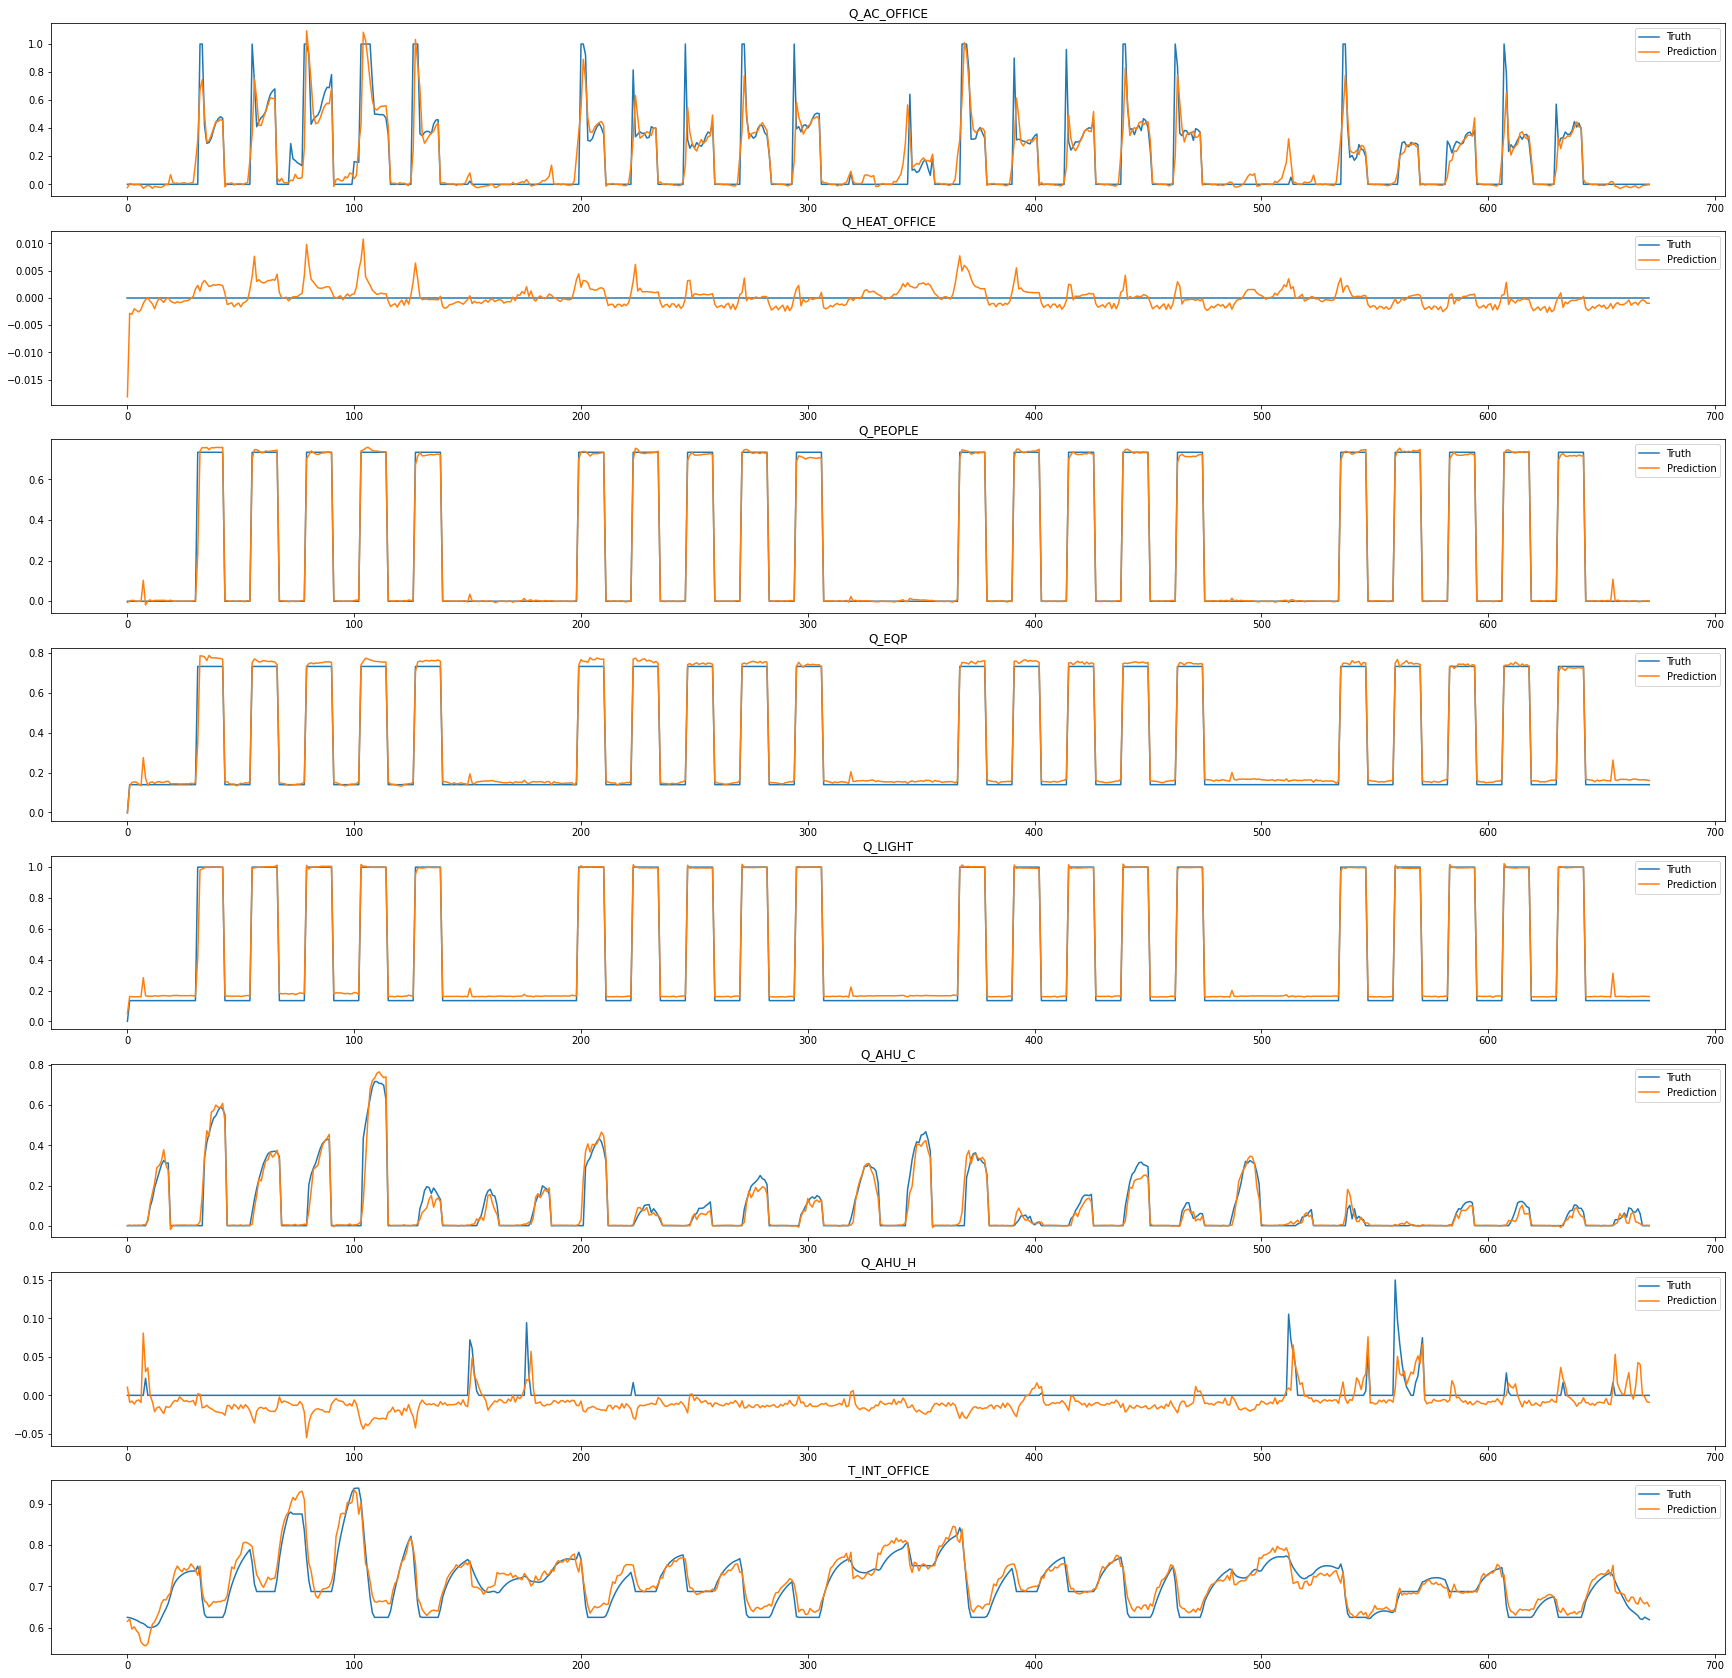

In [6]:
# Select training example
idx = np.random.randint(0, len(dataloader.dataset))
x, y = dataloader.dataset[idx]

# Run predictions
with torch.no_grad():
    x = torch.Tensor(x[np.newaxis, :, :])
    netout = net(x.to(device)).cpu().numpy()

plt.figure(figsize=(30, 30))
for idx_output_var in range(8):
    # Select real temperature
    y_true = y[:, idx_output_var]

    y_pred = netout[0, :, idx_output_var]

    plt.subplot(8, 1, idx_output_var+1)
    
    plt.plot(y_true, label="Truth")
    plt.plot(y_pred, label="Prediction")
    plt.title(dataloader.dataset.labels["X"][idx_output_var])
    plt.legend()
plt.savefig("fig")

# Evaluation

### Load evaluation dataset

In [7]:
dataset_eval = OzeEvaluationDataset(dataset_x_path="datasets/x_test_QK7dVsy.csv", labels_path="labels.json")
m_test = len(dataset_eval)

### Run prediction

In [8]:
predictions = np.zeros((m_test, K, 8))
with torch.no_grad():
    for idx, line in tqdm(enumerate(dataset_eval), total=m_test):
        # Run prediction
        netout = net(torch.Tensor(line[np.newaxis, :, :]).to(device)).cpu().numpy()
        
        # De-normalize output
        output = netout * (M - m + np.finfo(float).eps) + m
        predictions[idx] = output

100%|██████████| 500/500 [00:26<00:00, 18.85it/s]


### Export as csv

In [9]:
lines_output = predictions.reshape((m_test, -1))
csv_header = [f"{var_name}_{k}" for var_name in dataset_eval.labels['X'] for k in range(K)]

pd.DataFrame(lines_output, columns=csv_header).to_csv("y_bench.csv")